In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
# dataset_path = './custum_dataset'
dataset_path = './original_dataset'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [10]:
# Settings
feature_sets_path = './feature_sets_directory'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop'

In [11]:
# Load feature sets
feature_sets = np.load('/'.join([feature_sets_path, feature_sets_filename]))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [12]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [13]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77455, 16, 16)
(9733, 16, 16)
(9668, 16, 16)


In [14]:
# Peek at labels
print(y_val)

[ 2. 10. 21. ... 33.  2.  5.]


In [15]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [16]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [17]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.034110757217712936
0.965889242782287


In [18]:
# View the dimensions of our input data
print(x_train.shape)

(77455, 16, 16)


In [19]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77455, 16, 16, 1)
(9733, 16, 16, 1)
(9668, 16, 16, 1)


In [20]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [21]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [23]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [24]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
775/775 [==============================] - 18s 8ms/step - loss: 0.1134 - acc: 0.9669 - val_loss: 0.0730 - val_acc: 0.9761
Epoch 2/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0758 - acc: 0.9757 - val_loss: 0.0861 - val_acc: 0.9758
Epoch 3/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0642 - acc: 0.9800 - val_loss: 0.0509 - val_acc: 0.9837
Epoch 4/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0568 - acc: 0.9820 - val_loss: 0.0459 - val_acc: 0.9864
Epoch 5/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0538 - acc: 0.9837 - val_loss: 0.0409 - val_acc: 0.9889
Epoch 6/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0508 - acc: 0.9850 - val_loss: 0.0438 - val_acc: 0.9870
Epoch 7/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0529 - acc: 0.9844 - val_loss: 0.0489 - val_acc: 0.9852
Epoch 8/30
775/775 [==============================] - 6s 7ms/step - loss: 0

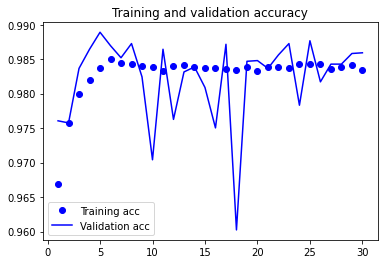

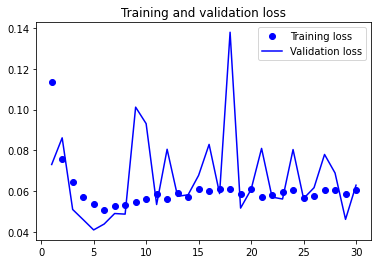

In [25]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
# Save the model as a file
models.save_model(model, model_filename)

In [27]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

13
25
28
44
67
69
73
110
112
132
133
166
184
254
255
269
293
346
354
356
399
435
444
448
454
565
569
610
611
615
633
637
693
696
703
713
719
725
731
759
783
819
860
903
936
956
963
965
986
994
1000
1009
1015
1036
1046
1061
1128
1142
1229
1233
1320
1376
1381
1510
1515
1605
1629
1707
1743
1748
1810
1815
1822
1829
1850
1920
1924
1929
1947
1990
2045
2049
2076
2106
2122
2124
2127
2180
2204
2206
2273
2383
2444
2453
2471
2482
2551
2553
2639
2643
2645
2694
2717
2777
2810
2822
2829
2842
2866
2924
2925
2978
3007
3059
3060
3089
3130
3159
3175
3226
3234
3297
3313
3371
3379
3428
3429
3446
3454
3458
3468
3475
3506
3541
3566
3604
3622
3657
3658
3659
3663
3673
3701
3727
3755
3782
3804
3849
3873
3910
3926
3957
3979
3980
3994
4008
4009
4011
4014
4038
4044
4076
4080
4093
4113
4137
4148
4150
4182
4207
4239
4245
4252
4271
4278
4279
4293
4294
4333
4461
4489
4494
4496
4523
4549
4623
4748
4768
4797
4833
4879
4904
4971
4980
4988
5008
5027
5036
5098
5128
5156
5252
5271
5315
5384
5408
5442
5461
5468
5471
5480
54

In [28]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[1.1360691e-09]]
Answer: 0.0  Prediction: [[8.298913e-20]]
Answer: 0.0  Prediction: [[2.9596772e-28]]
Answer: 0.0  Prediction: [[0.00120712]]
Answer: 0.0  Prediction: [[8.705881e-09]]
Answer: 0.0  Prediction: [[2.1326288e-10]]
Answer: 0.0  Prediction: [[4.4362996e-06]]
Answer: 0.0  Prediction: [[2.3916868e-13]]
Answer: 0.0  Prediction: [[0.00072083]]
Answer: 0.0  Prediction: [[6.130545e-08]]


In [29]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

303/303 [==============================] - 1s 3ms/step - loss: 0.0951 - acc: 0.9810


[0.0951433852314949, 0.9809681177139282]